Use conda environment conda_envs/cool_env.yml to run this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bbi
import pybedtools as pbt
import cooler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.stats as st
import warnings

In [2]:
import matplotlib as mpl

mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

Uploading of contact maps and defining regions with NaN values of contact frequency

In [3]:
clr_en = cooler.Cooler('/path/to/data/MTG_LEC_A46_FI_M1C_V1C_Pir_A24.EN.29_42_58_years.17356_cells.1kb.mcool::/resolutions/10000')
clr_in = cooler.Cooler('/path/to/data/MTG_LEC_A46_FI_M1C_V1C_Pir_A24.IN.29_42_58_years.17356_cells.1kb.mcool::/resolutions/10000')

In [4]:
all_white = []
chroms = [c.values[0] for c in clr_en.chroms()['name']]
clrs = [clr_en, clr_in]
for clr in clrs:
    for chrom in chroms:
        white_for_1chrom = clr.bins().fetch(chrom)[np.isnan(clr.bins().fetch(chrom)['weight'])].reset_index()
        all_white.append(white_for_1chrom)
all_white_bins = pd.concat(all_white)[['chrom', 'start', 'end']].sort_values(by=['chrom', 'start']).drop_duplicates().reset_index(drop=True)
allwhitebins = pbt.BedTool.from_dataframe(all_white_bins)
all_white_bins = allwhitebins.merge().to_dataframe()
all_white_bins['start'] = np.where((all_white_bins['start'] - 50000) > 0, all_white_bins['start'] - 50000, 0)
all_white_bins['end'] = all_white_bins['end'] + 50000
allwhitebins = pbt.BedTool.from_dataframe(all_white_bins)

Defining gene names, promotor regions of which form Polycomb-mediated contacts

In [5]:
polycomb_sites = ['PAX7', 'RUNX3', 'RNF220', 'DMBX1', 'TAL1', 'FOXD2', 'DMRTA2', 'FOXD3', 'LHX8', 'BARHL2', 'GFI1', 'TBX15', 'LMX1A', 'LHX4', 
                  'LHX9', 'NR5A2', 'PROX1', 'HLX', 'NUP133', 'GATA3', 'SPAG6', 'PTF1A', 'GAD2', 'SEC24C', 'ZNF503', 'PGAM1', 'NKX2-3', 'PAX2', 
                  'LBX1', 'PPRC1', 'NOLC1', 'CUEDC2', 'VAX1', 'EMX2', 'HMX3', 'EBF3', 'DBX1', 'SLC6A5', 'SLC17A6', 'PAX6', 'WT1', 'ALX4', 'BSX', 'FLI1',
                  'BARX2', 'HOXC13', 'HOXC12', 'HOXC11', 'HOXC10', 'HOXC9', 'HOXC8', 'HOXC4', 'HOXC5', 'HMGA2', 'ALX1', 'CUX2', 'LHX5', 'TBX5', 'TBX3', 
                  'FZD10', 'GJA3', 'GJB2', 'GJB6', 'GSX1', 'PDX1', 'CDX2', 'PCDH8', 'POU4F1', 'SOX21', 'ZIC5', 'ZIC2', 'SOX1', 'FOXG1', 'SFTA3',
                  'PAX9', 'TTC6', 'FOXA1', 'OTX2', 'SIX6', 'C14orf39', 'SIX1', 'PRKCH', 'TMEM30B', 'GSC', 'MEIS2', 'ONECUT1', 'FOXB1', 'SKOR1',
                  'ISL2', 'NR2F2', 'SALL1', 'IRX3', 'IRX5', 'ZFHX3', 'FOXF1', 'FOXC2', 'FOXL1', 'HS3ST3B1', 'SLFN12', 'SLFN13', 'COPZ2', 'HOXB1', 
                  'HOXB2', 'HOXB4', 'HOXB5', 'HOXB3', 'HOXB6', 'HOXB8', 'HOXB9', 'HOXB7', 'IGF2BP1', 'TBX2', 'CBX2', 'CBX8', 'ADCYAP1', 'TGIF1', 
                  'GATA6', 'SKOR2', 'ONECUT2', 'RAX', 'GTF3C2', 'SIX3', 'SIX2', 'OTX1', 'MEIS1', 'VAX2', 'INO80B', 'WBP1', 'MOGS', 'PAX8', 'EN1',
                  'NR4A2', 'TBR1', 'MYO3B', 'GAD1', 'DLX1', 'DLX2', 'SP9', 'EVX2', 'HOXD13', 'HOXD12', 'HOXD11', 'HOXD10', 'HOXD9', 'HOXD8', 'HOXD3',
                  'HOXD4', 'HOXD1', 'SATB2', 'ZDBF2', 'PAX3', 'GBX2', 'NKX2-4', 'FOXA2', 'SLC32A1', 'OLIG2', 'OLIG1', 'RUNX1', 'SIM2', 'EOMES', 
                  'FEZF2', 'GATA2', 'SOX14', 'FOXL2', 'FOXL2NB', 'ZIC1', 'ZIC4', 'RSRC1', 'SHOX2', 'MECOM', 'SOX2', 'MSX1', 'HMX1', 'PHOX2B', 'GSX2', 
                  'NKX6-1', 'LEF1', 'PITX2', 'NEUROG2', 'POU4F2', 'HAND2', 'ANXA2R', 'ISL1', 'GPX8', 'CDC20B', 'MCIDAS', 'CCNO', 'FOXD1', 'WDR41', 'OTP',
                  'PRDM6', 'PITX1', 'POU4F3', 'HAND1', 'EBF1', 'TLX3', 'NKX2-5', 'MSX2', 'BTNL9', 'TFAP2D', 'TFAP2B', 'TBX18', 'CCNC', 'SIM1', 'LIN28B', 
                  'PRDM1', 'OSTM1', 'NR2E1', 'VGLL2', 'HEY2', 'TCF21', 'OLIG3', 'ULBP1', 'UNCX', 'TWIST1', 'FERD3L', 'SP8', 'IGF2BP3', 'HOXA1', 'HOXA2', 
                  'HOXA4', 'HOXA5', 'HOXA6', 'HOXA3', 'HOXA7', 'HOXA9', 'HOXA10', 'HOXA11', 'HOXA13', 'TBX20', 'DLX6', 'DLX5', 'FEZF1', 'EN2', 'CNPY1', 
                  'MNX1', 'GATA4', 'NKX2-6', 'EBF2', 'SOX17', 'ZFHX4', 'STK3', 'OSR2', 'DMRT1', 'DMRT3', 'DMRT2', 'NFIB', 'CDKN2A', 'PAX5', 'PGM5', 
                  'FOXB2', 'BARX1', 'FOXE1', 'ZFP37', 'LHX6', 'LHX2', 'LMX1B', 'TTF1', 'CFAP77', 'BARHL1', 'ARX', 'NBDY', 'ZIC3', 'SOX3']

Uploading gene coordinates

In [6]:
all_genes = pd.read_csv('/path/to/data/GENCODE.gene.id-name-type-pos.csv.gz', compression='gzip')
all_genes = all_genes[all_genes['gene.type'] == 'protein_coding']
all_genes['TSS'] = np.where(all_genes['strand'] == '+', all_genes['start'], all_genes['end'])
all_promotors = pd.DataFrame({'chrom': all_genes['chrom'], 'start': all_genes['TSS'].astype(int)-5000, 'end': all_genes['TSS'].astype(int)+5000, 'strand': all_genes['strand'], 'TSS': all_genes['gene.name']})
all_promotors = all_promotors.drop_duplicates('TSS').reset_index(drop=True)

In [7]:
genes = pbt.BedTool.from_dataframe(all_promotors)
all_promotors = genes.intersect(allwhitebins, c=True).to_dataframe(names=['chrom', 'start', 'end', 'strand', 'TSS', 'allwhite'])
all_promotors = all_promotors[all_promotors['allwhite'] == 0][['chrom', 'start', 'end', 'strand', 'TSS']].reset_index(drop=True)

Setting paths to ChIP-seq data for neurons (N) and oligodendrocytes (O)

In [8]:
TF_peaks_N = {'BMI1': pd.read_csv('/path/to/data/BMI1_NeuN_merged_peaks.narrowPeak', sep='\t', header=None).rename(columns={0: 'chrom', 1: 'start', 2: 'end'})[['chrom', 'start', 'end']], 
             'H3K27me3': pd.read_csv('/path/to/data/H3K27me3_NeuN_merged_peaks.broadPeak', sep='\t', header=None).rename(columns={0: 'chrom', 1: 'start', 2: 'end'})[['chrom', 'start', 'end']],
             'Ring1B': pd.read_csv('/path/to/data/Ring1B_NeuN_merged_peaks.narrowPeak', sep='\t', header=None).rename(columns={0: 'chrom', 1: 'start', 2: 'end'})[['chrom', 'start', 'end']]
             }

TF_pbt_peaks_N = {'BMI1': pbt.BedTool.from_dataframe(TF_peaks_N['BMI1']), 
                  'H3K27me3': pbt.BedTool.from_dataframe(TF_peaks_N['H3K27me3']), 
                  'Ring1B': pbt.BedTool.from_dataframe(TF_peaks_N['Ring1B'])
                 }

TF_bigwig_paths_N = {'BMI1': '/path/to/data/normalised_neun_ppois.bigwig',
                    'H3K27me3': '/path/to/data/normalised_neun_ppois.bigwig',
                    'CTCF': '/path/to/data/CTCF_DLPFC-NEUN_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig',
                    'Ring1B': '/path/to/data/normalised_neun_ppois.bigwig'
                    }

In [9]:
TF_peaks_O = {'BMI1': pd.read_csv('/path/to/data/BMI1_Olig_merged_peaks.narrowPeak', sep='\t', header=None).rename(columns={0: 'chrom', 1: 'start', 2: 'end'})[['chrom', 'start', 'end']], 
             'H3K27me3': pd.read_csv('/path/to/data/H3K27me3_Olig_merged_peaks.broadPeak', sep='\t', header=None).rename(columns={0: 'chrom', 1: 'start', 2: 'end'})[['chrom', 'start', 'end']],
             'Ring1B': pd.read_csv('/path/to/data/Ring1B_Olig_merged_peaks.narrowPeak', sep='\t', header=None).rename(columns={0: 'chrom', 1: 'start', 2: 'end'})[['chrom', 'start', 'end']]
             }

TF_pbt_peaks_O = {'BMI1': pbt.BedTool.from_dataframe(TF_peaks_O['BMI1']), 
                  'H3K27me3': pbt.BedTool.from_dataframe(TF_peaks_O['H3K27me3']), 
                  'Ring1B': pbt.BedTool.from_dataframe(TF_peaks_O['Ring1B'])
                 }

TF_bigwig_paths_O = {'BMI1': '/path/to/data/normalised_olig_ppois.bigwig',
                    'H3K27me3': '/path/to/data/normalised_olig_ppois.bigwig',
                    'CTCF': '/path/to/data/CTCF_DLPFC-OLIG_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig',
                    'Ring1B': '/path/to/data/normalised_olig_ppois.bigwig'
                    }

In [10]:
all_TF_N = {}
for key in TF_pbt_peaks_N.keys():
    genes = pbt.BedTool.from_dataframe(all_promotors)
    TF_nowhite = TF_pbt_peaks_N[key].intersect(allwhitebins, c=True).to_dataframe()
    TF_nowhite = TF_nowhite[TF_nowhite['name'] == 0]
    TF_nowhite = pbt.BedTool.from_dataframe(TF_nowhite[['chrom', 'start', 'end']])
    intersect = TF_nowhite.intersect(genes, wa=True, wb=True)
    all_TF_N[key] = intersect.to_dataframe(names = ['chrom', 'start', 'end', 'geneChr', 'geneStart', 'geneEnd',  'geneStrand', 'geneName'])

all_TF_O = {}
for key in TF_pbt_peaks_O.keys():
    genes = pbt.BedTool.from_dataframe(all_promotors)
    TF_nowhite = TF_pbt_peaks_O[key].intersect(allwhitebins, c=True).to_dataframe()
    TF_nowhite = TF_nowhite[TF_nowhite['name'] == 0]
    TF_nowhite = pbt.BedTool.from_dataframe(TF_nowhite[['chrom', 'start', 'end']])
    intersect = TF_nowhite.intersect(genes, wa=True, wb=True)
    all_TF_O[key] = intersect.to_dataframe(names = ['chrom', 'start', 'end', 'geneChr', 'geneStart', 'geneEnd',  'geneStrand', 'geneName'])

Defining if ChIP-seq peak overlaps TSS

In [11]:
def cross(x, y, n):
    if n >= x and n <= y:
        return True
    else:
        return False

In [12]:
for key in all_TF_N.keys():
    peaks = all_TF_N[key]
    peaks['cross'] = False
    for i, irow in peaks.iterrows():
        peaks.loc[i, 'cross'] = cross(irow['start'], irow['end'], (irow['geneStart']+irow['geneEnd'])/2)

for key in all_TF_O.keys():
    peaks = all_TF_O[key]
    peaks['cross'] = False
    for i, irow in peaks.iterrows():
        peaks.loc[i, 'cross'] = cross(irow['start'], irow['end'], (irow['geneStart']+irow['geneEnd'])/2)

In [13]:
selected_TFs = {'H3K27me3_NeuN': TF_bigwig_paths_N['H3K27me3'], 
                'BMI1_NeuN': TF_bigwig_paths_N['BMI1'], 
                'H3K27me3_Olig': TF_bigwig_paths_O['H3K27me3'], 
                'BMI1_Olig': TF_bigwig_paths_O['BMI1'],
                'Ring1B_NeuN': TF_bigwig_paths_N['Ring1B'],
                'Ring1B_Olig': TF_bigwig_paths_O['Ring1B']}

In [14]:
for key in all_TF_N.keys():
    if len(all_TF_N[key]) > 0:
        all_TF_N[key]['len'] = all_TF_N[key]['end']-all_TF_N[key]['start']

for key in all_TF_O.keys():
    if len(all_TF_O[key]) > 0:
        all_TF_O[key]['len'] = all_TF_O[key]['end']-all_TF_O[key]['start']

BMI1 15256
H3K27me3 9054
CTCF 12273
Ring1B 192
BMI1 13701
H3K27me3 6305
CTCF 13099
Ring1B 30


Making a dataset of all promotors overlapping with any of ChIP-seq peaks

In [15]:
neun_me3 = all_TF_N['H3K27me3'][['chrom', 'geneStart', 'geneEnd', 'len', 'geneName', 'geneStrand']]
olig_me3 = all_TF_O['H3K27me3'][['chrom', 'geneStart', 'geneEnd', 'len', 'geneName', 'geneStrand']]
neun_bmi = all_TF_N['BMI1'][['chrom', 'geneStart', 'geneEnd', 'len', 'geneName', 'geneStrand']]
olig_bmi = all_TF_O['BMI1'][['chrom', 'geneStart', 'geneEnd', 'len', 'geneName', 'geneStrand']]
neun_ring1b = all_TF_N['Ring1B'][['chrom', 'geneStart', 'geneEnd', 'len', 'geneName', 'geneStrand']]
olig_ring1b = all_TF_O['Ring1B'][['chrom', 'geneStart', 'geneEnd', 'len', 'geneName', 'geneStrand']]

neun_me3 = neun_me3.drop_duplicates('geneName')
olig_me3 = olig_me3.drop_duplicates('geneName')
neun_bmi = neun_bmi.drop_duplicates('geneName')
olig_bmi = olig_bmi.drop_duplicates('geneName')
neun_ring1b = neun_ring1b.drop_duplicates('geneName')
olig_ring1b = olig_ring1b.drop_duplicates('geneName')

neun_me3 = neun_me3.rename(columns={'geneStart': 'start', 'geneEnd': 'end'})
olig_me3 = olig_me3.rename(columns={'geneStart': 'start', 'geneEnd': 'end'})
neun_bmi = neun_bmi.rename(columns={'geneStart': 'start', 'geneEnd': 'end'})
olig_bmi = olig_bmi.rename(columns={'geneStart': 'start', 'geneEnd': 'end'})
neun_ring1b = neun_ring1b.rename(columns={'geneStart': 'start', 'geneEnd': 'end'})
olig_ring1b = olig_ring1b.rename(columns={'geneStart': 'start', 'geneEnd': 'end'})

neun_me3 = neun_me3.reset_index(drop=True)
olig_me3 = olig_me3.reset_index(drop=True)
neun_bmi = neun_bmi.reset_index(drop=True)
olig_bmi = olig_bmi.reset_index(drop=True)
neun_ring1b = neun_ring1b.reset_index(drop=True)
olig_ring1b = olig_ring1b.reset_index(drop=True)

all_df = pd.concat([neun_me3, olig_me3, neun_bmi, olig_bmi, neun_ring1b, olig_ring1b])
all_df = all_df.drop_duplicates('geneName')

Calculating of average ChIP-seq signal for all the tracks for every bin within 20kb radius around TSS

In [ ]:
offset, nbins = 20000, 100
feature_path = selected_TFs

plot_df = all_df
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start'] = plot_df['mid'] - offset
plot_df['end'] = plot_df['mid'] + offset
plot_df = plot_df.rename(columns={'geneStrand': 'strand'})

for j, (name, path) in enumerate(feature_path.items()):
    s = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
    s[(plot_df['strand'] == '-').values, :] = np.fliplr(s[(plot_df['strand'] == '-').values, :])
    row_sum = s.sum(axis=1)
    all_df[name] = row_sum

Z-normalisation and K-means clusterisation

In [17]:
for name in feature_path.keys():
    all_df[f'{name}_zscore'] = st.zscore(all_df[name])

In [18]:
zscores = all_df.filter(like='_zscore', axis=1)

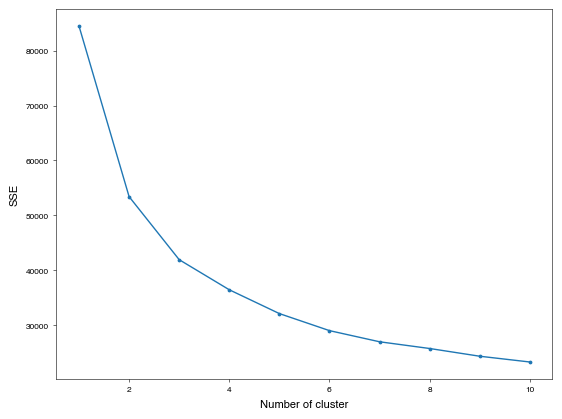

In [19]:
warnings.filterwarnings("ignore")

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(zscores)
    zscores.loc[:, "clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        
plt.figure()
plt.scatter(list(sse.keys()), list(sse.values()), s=3)
plt.plot(list(sse.keys()), list(sse.values()), linewidth=1)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [20]:
m = 10
zscores = zscores.drop(columns='clusters')
pca = PCA()
pca_components = pca.fit_transform(zscores)
kmeans = KMeans(n_clusters=m, max_iter=10000, random_state=21)
label = kmeans.fit_predict(zscores)
zscores.loc[:, "clusters"] = label

In [22]:
data = pd.merge(all_df, zscores, on = ['H3K27me3_NeuN_zscore', 
                                       'H3K27me3_Olig_zscore', 
                                       'BMI1_NeuN_zscore', 
                                       'BMI1_Olig_zscore',
                                       'Ring1B_NeuN_zscore',
                                       'Ring1B_Olig_zscore'])

data['plc'] = np.where(data['geneName'].isin(polycomb_sites), True, False)

Adding data for expression levels and CpG island overlapping

In [23]:
exp = pd.read_csv('/path/to/data/kozlenkov.logTPM_counts.csv.gz')
exp = exp.rename(columns={'gene.name': 'geneName'})
exp = exp[['geneName', 'log2TPM_pl_1_GLU', 'log2TPM_pl_1_GABA', 'log2TPM_pl_1_OLIG']]

In [24]:
cpg = pd.read_csv('cpgIslandExt.hg38.bed', sep='\t', header = None)
cpg = cpg.rename(columns = {0:'chrom', 1:'start', 2:'end', 3:'name', 4:'length', 5:'cpgNum', 6:'gcNum', 7:'perCpg', 8:'perGc', 9:'obsExp'})
cpg = cpg[['chrom', 'start', 'end']]

In [25]:
data['start'] = data['start'].astype('int') - 5000
data['end'] = data['end'].astype('int') + 5000

data_pbt = pbt.BedTool.from_dataframe(data)
cpg_pbt = pbt.BedTool.from_dataframe(cpg)
data = data_pbt.intersect(cpg_pbt, wao=True).to_dataframe(names = list(data.columns)+['cpg_chr', 'cpg_start', 'cpg_end', 'CpGoverlap'])
data['cpg'] = np.where(data['CpGoverlap'] > 0, True, False)
data['CpGlen'] = np.where(data['cpg'], data['cpg_end']-data['cpg_start'], 0)

In [26]:
data = data.groupby(['chrom', 'start', 'end', 'len', 'geneName', 'geneStrand', 'mid',
       'H3K27me3_NeuN', 'BMI1_NeuN', 'Ring1B_NeuN',
        'H3K27me3_Olig', 'BMI1_Olig', 'Ring1B_Olig',
       'H3K27me3_NeuN_zscore', 'BMI1_NeuN_zscore', 'Ring1B_NeuN_zscore',
        'H3K27me3_Olig_zscore', 'BMI1_Olig_zscore', 'Ring1B_Olig_zscore',
        'clusters', 'plc'])[['CpGlen', 'CpGoverlap']].sum().reset_index()
data['cpg'] = np.where(data['CpGoverlap'] > 0, True, False)

In [27]:
all_genes['geneLen'] = all_genes['end']-all_genes['start']
data = pd.merge(data, all_genes[['gene.name', 'geneLen']], left_on = 'geneName', right_on = 'gene.name')
data = pd.merge(data, exp, on='geneName')
data = data.drop_duplicates('geneName')

In [28]:
len(data)

14078

Plotting all the data on heatmap

In [29]:
cl1 = data[data['clusters'] == 0].reset_index(drop=True)
cl2 = data[data['clusters'] == 1].reset_index(drop=True)
cl3 = data[data['clusters'] == 2].reset_index(drop=True)
cl4 = data[data['clusters'] == 3].reset_index(drop=True)
cl5 = data[data['clusters'] == 4].reset_index(drop=True)
cl6 = data[data['clusters'] == 5].reset_index(drop=True)
cl7 = data[data['clusters'] == 6].reset_index(drop=True)
cl8 = data[data['clusters'] == 7].reset_index(drop=True)
cl9 = data[data['clusters'] == 8].reset_index(drop=True)
cl10 = data[data['clusters'] == 9].reset_index(drop=True)

In [79]:
selected_TFs = {
                'H3K27me3_NeuN': TF_bigwig_paths_N['H3K27me3'], 
                'H3K27me3_Olig': TF_bigwig_paths_O['H3K27me3'],
                'BMI1_NeuN': TF_bigwig_paths_N['BMI1'], 
                'BMI1_Olig': TF_bigwig_paths_O['BMI1'],
                'Ring1B_NeuN':  TF_bigwig_paths_N['Ring1B'],
                'Ring1B_Olig':  TF_bigwig_paths_O['Ring1B'],
                'CTCF_NeuN': TF_bigwig_paths_N['CTCF'], 
                'CTCF_Olig': TF_bigwig_paths_O['CTCF']
               }

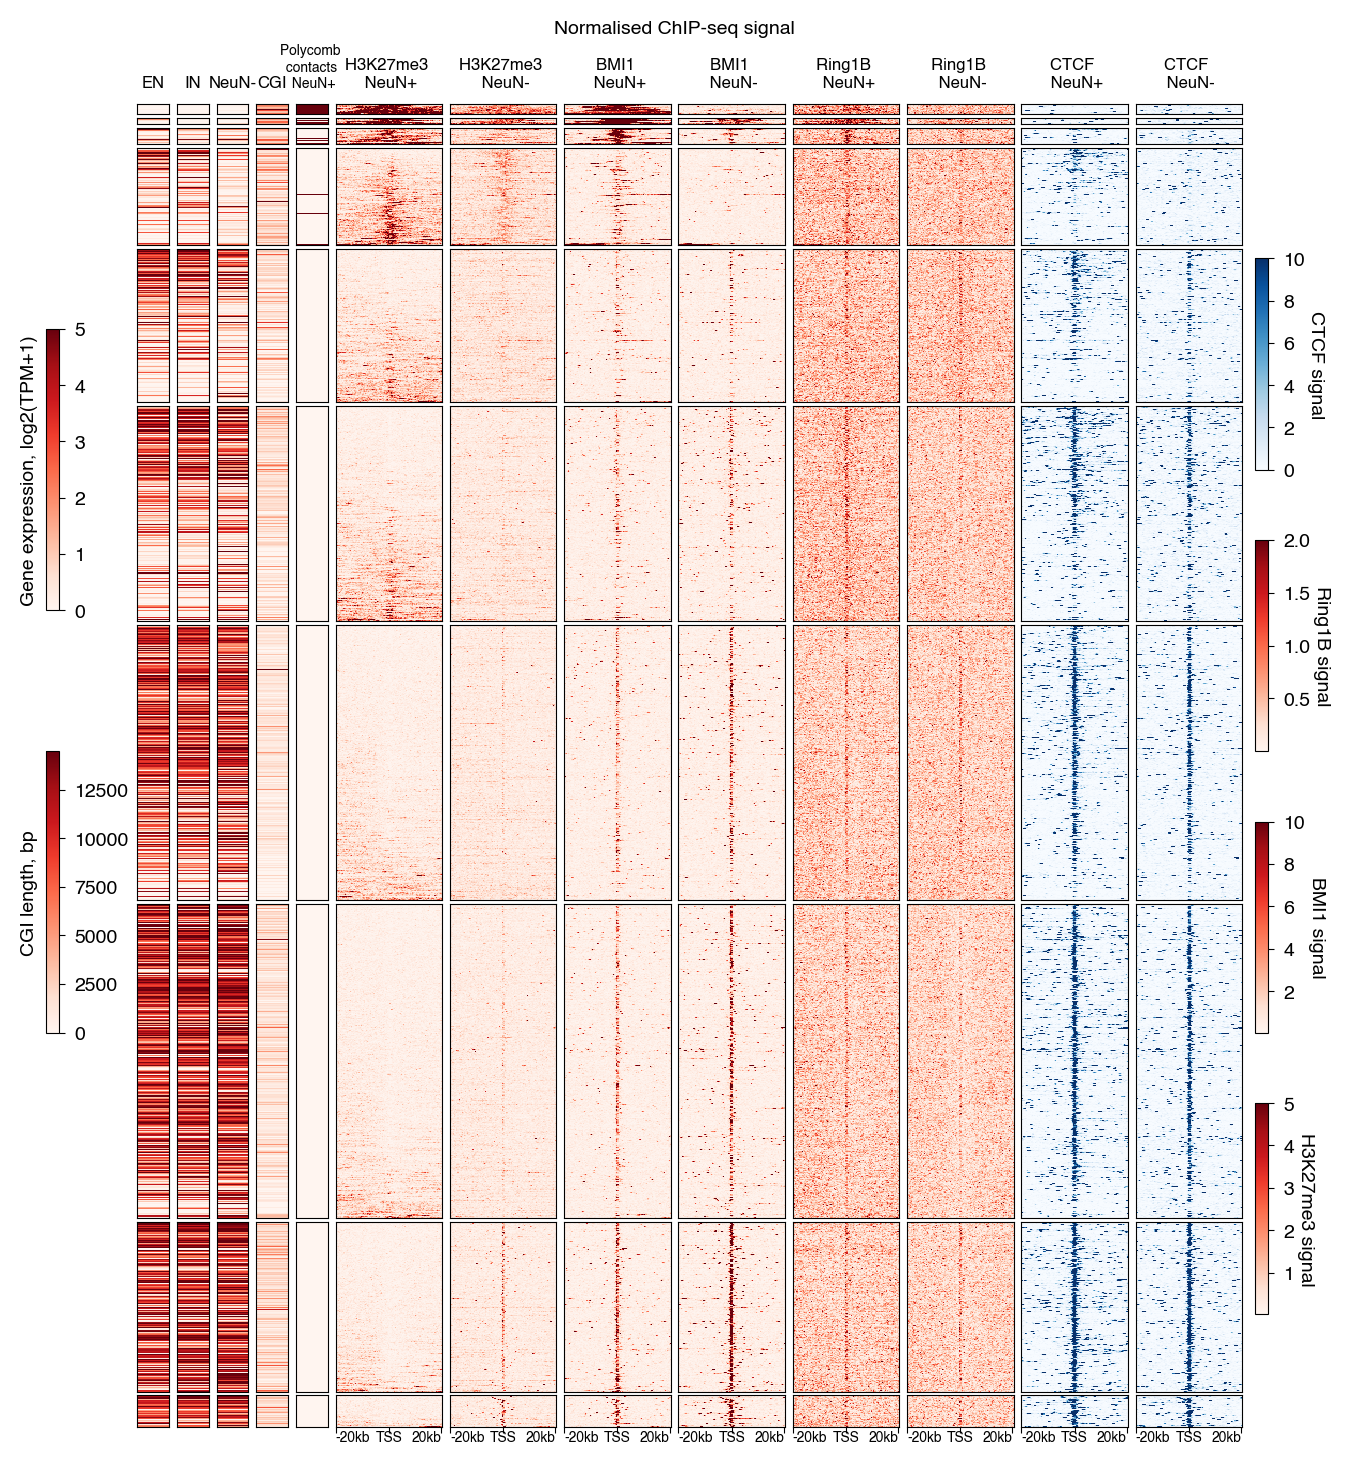

In [80]:
df = [cl10, cl3, cl4, cl1, cl8, cl7, cl9, cl5, cl2, cl6]
offset, nbins = 20000, 100
feature_path = selected_TFs

row_heights = [df_i.shape[0] for df_i in df]

fig, axs = plt.subplots(len(df), len(feature_path)+5, dpi=200, 
                        figsize=[(len(feature_path)+5)*0.5, sum([0.0005 * h for h in row_heights])],
                        gridspec_kw={'height_ratios': row_heights, 'width_ratios': [0.3]*5 + [1]*len(feature_path)})

plt.subplots_adjust(hspace=0.03, wspace=0.1, top=0.96, bottom=0.02, left=0.1, right=0.95)

start_col = 5 
end_col = 10 

x_position = (axs[0, 5].get_position().x0 + axs[0, 10].get_position().x1) / 2
fig.text(x_position, 1.02, 'Normalised ChIP-seq signal', 
         ha='center', va='top', fontsize=7)

cbar_added = {'H3K27me3_NeuN': False, 'BMI1_NeuN': False, 'Ring1B_NeuN': False, 'CTCF_NeuN': False, 
              'CpGlen': False, 'GenExp': False}
names = range(1, 11)

for i in range(len(df)):
    plot_df = df[i].reset_index(drop=True)
    plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
    plot_df['start'] = plot_df['mid'] - offset
    plot_df['end'] = plot_df['mid'] + offset
    plot_df = plot_df.rename(columns={'geneStrand': 'strand'})

    for j, (name, path) in enumerate(feature_path.items()):
        s = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
        s[(plot_df['strand'] == '-').values, :] = np.fliplr(s[(plot_df['strand'] == '-').values, :])
        if name == 'H3K27me3_NeuN':
            row_sum = s.sum(axis=1)
            row_ord = np.argsort(row_sum)

    s = []
    for k in range(len(plot_df)):
        s.append(np.array([plot_df.loc[k, 'log2TPM_pl_1_GLU']]*nbins))
    s = np.asarray(s)    
    im0 = axs[i, 0].imshow(s[row_ord, :], aspect='auto', interpolation='nearest', cmap='Reds', vmax=5, vmin=0,
                                extent=[0, nbins, 0, plot_df.shape[0]]) 
    if i == 0:
        axs[i, 0].set_title('EN', fontsize=6)

    axs[i, 0].set_yticks([])
    axs[i, 0].set_yticklabels([])    
    axs[i, 0].set_xticks([])

    s = []
    for k in range(len(plot_df)):
        s.append(np.array([plot_df.loc[k, 'log2TPM_pl_1_GABA']]*nbins))
    s = np.asarray(s)    
    im1 = axs[i, 1].imshow(s[row_ord, :], aspect='auto', interpolation='nearest', cmap='Reds', vmax=5, vmin=0,
                                extent=[0, nbins, 0, plot_df.shape[0]]) 
    if i == 0:
        axs[i, 1].set_title('IN', fontsize=6)

    axs[i, 1].set_yticks([])
    axs[i, 1].set_yticklabels([])    
    axs[i, 1].set_xticks([])

    s = []
    for k in range(len(plot_df)):
        s.append(np.array([plot_df.loc[k, 'log2TPM_pl_1_OLIG']]*nbins))
    s = np.asarray(s)    
    im2 = axs[i, 2].imshow(s[row_ord, :], aspect='auto', interpolation='nearest', cmap='Reds', vmax=5, vmin=0,
                                extent=[0, nbins, 0, plot_df.shape[0]]) 

    if i == 0:
        axs[i, 2].set_title('NeuN-', fontsize=6)
        
    axs[i, 2].set_yticks([])
    axs[i, 2].set_yticklabels([])    
    axs[i, 2].set_xticks([])

    s = []
    for k in range(len(plot_df)):
        if plot_df.loc[k, 'cpg'] == True:
            s.append(np.array([plot_df.loc[k, 'CpGoverlap']]*nbins))
        else:
            s.append(np.array([0]*nbins))
    s = np.asarray(s)     
    im3 = axs[i, 3].imshow(s[row_ord, :], aspect='auto', interpolation='nearest', cmap='Reds', vmin=0,
                                extent=[0, nbins, 0, plot_df.shape[0]]) 
    if i == 0:
        axs[i, 3].set_title('CGI', fontsize=6)

    axs[i, 3].set_yticks([])
    axs[i, 3].set_yticklabels([])    
    axs[i, 3].set_xticks([])
    
    s = []
    for k in range(len(plot_df)):
        if plot_df.loc[k, 'plc'] == True:
            s.append(np.array([1]*nbins))
        else:
            s.append(np.array([0]*nbins))
    s = np.asarray(s)     
    axs[i, 4].imshow(s[row_ord, :], aspect='auto', interpolation='nearest', cmap='Reds', vmax=1, vmin=0,
                                extent=[0, nbins, 0, plot_df.shape[0]]) 
    if i == 0:
        axs[i, 4].set_title('Polycomb \n contacts \n NeuN+', fontsize=5)

    axs[i, 4].set_yticks([])
    axs[i, 4].set_yticklabels([])
    axs[i, 4].set_xticks([])

    for j, (name, path) in enumerate(feature_path.items()):
        s = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
        s[(plot_df['strand'] == '-').values, :] = np.fliplr(s[(plot_df['strand'] == '-').values, :])

        tf, ct = name.strip().split('_')
        if tf == 'BMI1':
            vmax = 10
        elif tf == 'Ring1B':
            vmax = 2
        elif tf == 'CTCF':
            vmax = 10
        elif tf == 'H3K27me3':
            vmax = 5

        im = axs[i, j+5].imshow(s[row_ord, :], aspect='auto', interpolation='nearest', cmap='Reds', vmax=vmax,
                                extent=[0, nbins, 0, plot_df.shape[0]])
        
        if 'CTCF'  in name:
            im4 = axs[i, j+5].imshow(s[row_ord, :], aspect='auto', interpolation='nearest', cmap='Blues', vmax=vmax,
                                extent=[0, nbins, 0, plot_df.shape[0]])

        if i == 0:
            name = name.split('_')
            if name[1] == 'NeuN':
                celltype = 'NeuN+'
            else:
                celltype = 'NeuN-'
            axs[i, j+5].set_title(f'{name[0]} \n {celltype}', fontsize=6)
        axs[i, j+5].set_yticklabels([])
        axs[i, j+5].set_yticks([])
        
        if i == len(df)-1:
            ticks = [0, nbins // 2, nbins - 1]
            labels = ['-20kb', 'TSS', '20kb']
            axs[i, j+5].set_xticks(ticks)
            axs[i, j+5].set_xticklabels([])
            for tick, label in zip(ticks, labels):
                if label == '-20kb':
                    ha = 'left'
                elif label == 'TSS':
                    ha = 'center'
                else:
                    ha = 'right'
                axs[i, j+5].text(tick, -0.1, label, ha=ha, va='top', fontsize=5, transform=axs[i, j+5].get_xaxis_transform())
        else:
            axs[i, j+5].set_xticks([])

        if name == 'H3K27me3_NeuN' and not cbar_added['H3K27me3_NeuN']:
            cbar_ax = fig.add_axes([0.96, 0.10, 0.01, 0.15])
            cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
            cbar.set_label('H3K27me3 signal', fontsize=7, rotation=270, labelpad=7)
            cbar_ax.yaxis.set_label_position('right')
            cbar.ax.tick_params(labelsize=7)
            cbar_added['H3K27me3_NeuN'] = True
        
        if name == 'BMI1_NeuN' and not cbar_added['BMI1_NeuN']:
            cbar_ax = fig.add_axes([0.96, 0.30, 0.01, 0.15]) 
            cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
            cbar.set_label('BMI1 signal', fontsize=7, rotation=270, labelpad=7)
            cbar_ax.yaxis.set_label_position('right')
            cbar.ax.tick_params(labelsize=7)
            cbar_added['BMI1_NeuN'] = True

        if name == 'Ring1B_NeuN' and not cbar_added['Ring1B_NeuN']:
            cbar_ax = fig.add_axes([0.96, 0.50, 0.01, 0.15]) 
            cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
            cbar.set_label('Ring1B signal', fontsize=7, rotation=270, labelpad=7)
            cbar_ax.yaxis.set_label_position('right')
            cbar.ax.tick_params(labelsize=7)
            cbar_added['Ring1B_NeuN'] = True

        if name == 'CTCF_NeuN' and not cbar_added['CTCF_NeuN']:
            cbar_ax = fig.add_axes([0.96, 0.70, 0.01, 0.15])
            cbar = fig.colorbar(im4, cax=cbar_ax, orientation='vertical')
            cbar.set_label('CTCF signal', fontsize=7, rotation=270, labelpad=7)
            cbar_ax.yaxis.set_label_position('right')
            cbar.ax.tick_params(labelsize=7)
            cbar_added['CTCF_NeuN'] = True

        if not cbar_added['CpGlen']:
            cbar_ax = fig.add_axes([0.03, 0.3, 0.01, 0.2]) 
            cbar = fig.colorbar(im3, cax=cbar_ax, orientation='vertical')
            cbar.set_label('CGI length, bp', fontsize=7, rotation=90, labelpad=3)
            cbar_ax.yaxis.set_label_position('left')
            cbar.ax.tick_params(labelsize=7)
            cbar_added['CpGlen'] = True

        if not cbar_added['GenExp']:
            cbar_ax = fig.add_axes([0.03, 0.6, 0.01, 0.2]) 
            cbar = fig.colorbar(im0, cax=cbar_ax, orientation='vertical')
            cbar.set_label('Gene expression, log2(TPM+1)', fontsize=7, rotation=90, labelpad=3)
            cbar_ax.yaxis.set_label_position('left')
            cbar.ax.tick_params(labelsize=7)
            cbar_added['GenExp'] = True
            
# plt.savefig('heatmap_h3k27me3_bmi1_ring1b_final.pdf', format='pdf', bbox_inches='tight')
plt.show()

Calculating of average ChIP-seq signal for polycomb-associated and not polycomb-associated sets of clusters separately

In [30]:
polycomb_clust = pd.concat([cl10, cl3])[['chrom', 'start', 'end', 'mid', 'geneStrand']].sort_values(by=['chrom', 'start']).reset_index(drop=True)

In [32]:
npclust = pd.concat([cl1, cl2, cl4, cl5, cl6, cl7, cl8, cl9])[['chrom', 'start', 'end', 'mid', 'geneStrand']].sort_values(by=['chrom', 'start']).reset_index(drop=True)

In [33]:
selected_TFs = {
                'H3K27me3': {'Neun': TF_bigwig_paths_N['H3K27me3'], 'Olig': TF_bigwig_paths_O['H3K27me3']}, 
                'BMI1': {'Neun': TF_bigwig_paths_N['BMI1'], 'Olig':  TF_bigwig_paths_O['BMI1']},
                'Ring1B': {'Neun': TF_bigwig_paths_N['Ring1B'], 'Olig': TF_bigwig_paths_O['Ring1B']}
               }

In [34]:
offset, nbins = 20000, 100
feature_path = selected_TFs
polycomb_stackup = {}
polycomb_sem = {}

plot_df = polycomb_clust.reset_index(drop=True)
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start'] = plot_df['mid'] - offset
plot_df['end'] = plot_df['mid'] + offset
plot_df = plot_df.rename(columns={'geneStrand': 'strand'})

for j, (name, data) in enumerate(feature_path.items()):
    polycomb_stackup[name] = {}
    polycomb_sem[name] = {}
    for key in data:
        s = bbi.stackup(data[key], plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
        s[(plot_df['strand'] == '-').values, :] = np.fliplr(s[(plot_df['strand'] == '-').values, :])
        polycomb_stackup[name][key] = np.mean(s, axis=0)
        polycomb_sem[name][key] = np.std(s, axis=0) / np.sqrt(len(s))

In [35]:
nonpolycomb_stackup = {}
nonpolycomb_sem = {}

plot_df = npclust.reset_index(drop=True)
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start'] = plot_df['mid'] - offset
plot_df['end'] = plot_df['mid'] + offset
plot_df = plot_df.rename(columns={'geneStrand': 'strand'})

for j, (name, data) in enumerate(feature_path.items()):
    nonpolycomb_stackup[name] = {}
    nonpolycomb_sem[name] = {}
    for key in data:
        s = bbi.stackup(data[key], plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
        s[(plot_df['strand'] == '-').values, :] = np.fliplr(s[(plot_df['strand'] == '-').values, :])
        nonpolycomb_stackup[name][key] = np.mean(s, axis=0)
        nonpolycomb_sem[name][key] = np.std(s, axis=0) / np.sqrt(len(s))

In [37]:
colors = {'Neun': '#6b6ecfff', 'Olig': '#ff7f0eff'}

Calculating of ChIP-seq signal for central bin of every region

In [38]:
central_pixels_both = pd.DataFrame(columns = ['chip_type', 'Neun', 'Olig'])

In [39]:
offset, nbins = 20000, 100
feature_path = selected_TFs

plot_df = polycomb_clust.reset_index(drop=True)
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start'] = plot_df['mid'] - offset
plot_df['end'] = plot_df['mid'] + offset
plot_df = plot_df.rename(columns={'geneStrand': 'strand'})

for j, (name, data) in enumerate(feature_path.items()):
    subdata = pd.DataFrame(columns = ['chip_type', 'Neun', 'Olig'])
    for key in data:
        s = bbi.stackup(data[key], plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
        s[(plot_df['strand'] == '-').values, :] = np.fliplr(s[(plot_df['strand'] == '-').values, :])
        cent_bins = (s[:, int(nbins/2-1)] + s[:, int(nbins/2)]) / 2
        subdata[key] = cent_bins
        subdata['chip_type'] = name
    central_pixels_both = pd.concat([central_pixels_both, subdata])

In [40]:
central_pixels_np = pd.DataFrame(columns = ['chip_type', 'Neun', 'Olig'])

In [41]:
offset, nbins = 20000, 100
feature_path = selected_TFs

plot_df = npclust.reset_index(drop=True)
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start'] = plot_df['mid'] - offset
plot_df['end'] = plot_df['mid'] + offset
plot_df = plot_df.rename(columns={'geneStrand': 'strand'})

for j, (name, data) in enumerate(feature_path.items()):
    subdata = pd.DataFrame(columns = ['chip_type', 'Neun', 'Olig'])
    for key in data:
        s = bbi.stackup(data[key], plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
        s[(plot_df['strand'] == '-').values, :] = np.fliplr(s[(plot_df['strand'] == '-').values, :])
        cent_bins = (s[:, int(nbins/2-1)] + s[:, int(nbins/2)]) / 2
        subdata[key] = cent_bins
        subdata['chip_type'] = name
    central_pixels_np = pd.concat([central_pixels_np, subdata])

In [43]:
central_pixels_long_both = pd.melt(central_pixels_both, id_vars=['chip_type'], value_vars=['Neun', 'Olig'], var_name='cell_type', value_name='central_signal')

In [44]:
central_pixels_long_np = pd.melt(central_pixels_np, id_vars=['chip_type'], value_vars=['Neun', 'Olig'], var_name='cell_type', value_name='central_signal')

Comparing central bin signal levels with Wilcoxon test

In [49]:
pvals_both = {'H3K27me3': st.wilcoxon(central_pixels_both[central_pixels_both['chip_type'] == 'H3K27me3']['Neun'], central_pixels_both[central_pixels_both['chip_type'] == 'H3K27me3']['Olig'])[1],
        'BMI1': st.wilcoxon(central_pixels_both[central_pixels_both['chip_type'] == 'BMI1']['Neun'], central_pixels_both[central_pixels_both['chip_type'] == 'BMI1']['Olig'])[1],
        'Ring1B': st.wilcoxon(central_pixels_both[central_pixels_both['chip_type'] == 'Ring1B']['Neun'], central_pixels_both[central_pixels_both['chip_type'] == 'Ring1B']['Olig'])[1] 
        }

In [52]:
pvals_np = {'H3K27me3': st.wilcoxon(central_pixels_np[central_pixels_np['chip_type'] == 'H3K27me3']['Neun'], central_pixels_np[central_pixels_np['chip_type'] == 'H3K27me3']['Olig'])[1],
        'BMI1': st.wilcoxon(central_pixels_np[central_pixels_np['chip_type'] == 'BMI1']['Neun'], central_pixels_np[central_pixels_np['chip_type'] == 'BMI1']['Olig'])[1],
        'Ring1B': st.wilcoxon(central_pixels_np[central_pixels_np['chip_type'] == 'Ring1B']['Neun'], central_pixels_np[central_pixels_np['chip_type'] == 'Ring1B']['Olig'])[1] 
        }

In [64]:
colors = {'Neun': '#3924b1ff', 'Olig': '#ffc875ff'}

In [53]:
def pval_to_stars(pvals, chip):
    if pvals[chip] < 0.0001:
        p_text = "****"
    elif pvals[chip] < 0.001:
        p_text = "***"
    elif pvals[chip] < 0.01:
        p_text = "**"
    elif pvals[chip] < 0.05:
        p_text = "*"
    else:
        p_text = ""
    return p_text

In [54]:
plc = pd.concat([cl3, cl10]).reset_index(drop=True)
no_plc = pd.concat([cl1, cl2, cl4, cl5, cl6, cl7, cl8, cl9]).reset_index(drop=True)

In [55]:
colors = {'Neun': '#57366D', 'Olig': '#F49D6E'}

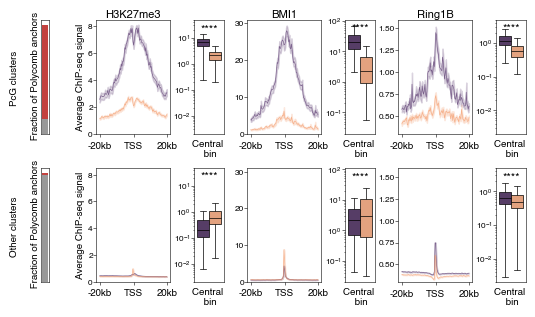

In [62]:
fig, axs = plt.subplots(2, 8, figsize = (5.7, 3.75),
                       gridspec_kw={'width_ratios': [0.1, 0.001, 1, 0.4, 1, 0.4, 1, 0.4], 'wspace': 0.6, 'hspace': 0.3})
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.9)

axs[0, 1].set_visible(False)
axs[1, 1].set_visible(False)

false_count, true_count = plc['plc'].value_counts().get(False, 0), plc['plc'].value_counts().get(True, 0)
total = false_count + true_count
false_percent = false_count / total
true_percent = true_count / total

axs[0][0].bar('plc', false_percent, color='#999999')
axs[0][0].bar('plc', true_percent, bottom=false_percent, color='#c3423f')
axs[0][0].set_xlabel('')
axs[0][0].set_ylabel('PcG clusters \n \n Fraction of Polycomb anchors', fontsize=7, labelpad=1)
axs[0][0].set_xticklabels([])
axs[0][0].set_yticklabels([])
axs[0][0].set_yticks([])
axs[0][0].set_xticks([])

axs[0][2].plot(range(0, 100), polycomb_stackup['H3K27me3']['Neun'], alpha=0.7, label='Neun', color = colors.get('Neun'), linewidth=0.5)
axs[0][2].plot(range(0, 100), polycomb_stackup['H3K27me3']['Olig'], alpha=0.7, label='Olig', color = colors.get('Olig'), linewidth=0.5)
axs[0][2].set_ylabel('Average ChIP-seq signal', fontsize=7, labelpad=2)  
axs[0][2].set_ylim(0, 8.5)
axs[0][2].set_title('H3K27me3', fontsize=8, pad=0.5)
# axs[0][2].legend(fontsize=7, loc='best', frameon=False, handlelength=1, handletextpad=0.5)
axs[0][2].fill_between(range(0, 100),
                polycomb_stackup['H3K27me3']['Neun'] - polycomb_sem['H3K27me3']['Neun'], 
                polycomb_stackup['H3K27me3']['Neun'] + polycomb_sem['H3K27me3']['Neun'], color=colors.get('Neun'), alpha=0.2)
axs[0][2].fill_between(range(0, 100),
                polycomb_stackup['H3K27me3']['Olig'] - polycomb_sem['H3K27me3']['Olig'], 
                polycomb_stackup['H3K27me3']['Olig'] + polycomb_sem['H3K27me3']['Olig'], color=colors.get('Olig'), alpha=0.2)

ticks = [0, nbins // 2, nbins - 1]
labels = ['-20kb', 'TSS', '20kb']

axs[0][2].set_xticks(ticks)
axs[0][2].set_xticklabels([])
axs[0][2].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[0][2].text(tick, -0.6, label, ha='center', va='top', fontsize=7)
    
sns.boxplot(data=central_pixels_long_both[central_pixels_long_both['chip_type'] == 'H3K27me3'], 
                y='central_signal', 
                hue='cell_type',
                palette=colors,
                linecolor = 'black',
                linewidth=0.5,
                width=0.8,
                ax=axs[0][3],
               showfliers=False)
y_max = central_pixels_long_both[central_pixels_long_both['chip_type'] == 'H3K27me3']['central_signal'].max() * 1  
x_pos = 0

axs[0][3].set_yscale('log')
axs[0][3].set_ylim(0.002, 50)
axs[0][3].set_xlabel('Central \n bin', fontsize=7)
axs[0][3].set_xticks([])
axs[0][3].set_ylabel('')
axs[0][3].tick_params(axis='y', labelsize=6, pad=0.5)
axs[0][3].text(x_pos, y_max, pval_to_stars(pvals_both, 'H3K27me3'), 
            ha='center', va='bottom', 
            fontsize=8
           )
axs[0][3].get_legend().remove()

axs[0][4].plot(range(0, 100), polycomb_stackup['BMI1']['Neun'], alpha=0.7, label=name, color = colors.get('Neun'), linewidth=0.5)
axs[0][4].plot(range(0, 100), polycomb_stackup['BMI1']['Olig'], alpha=0.7, label=name, color = colors.get('Olig'), linewidth=0.5)
axs[0][4].set_ylabel('')  
axs[0][4].set_ylim(0, 31)
axs[0][4].set_title('BMI1', fontsize=8, pad=0.5)
axs[0][4].fill_between(range(0, 100),
                polycomb_stackup['BMI1']['Neun'] - polycomb_sem['BMI1']['Neun'], 
                polycomb_stackup['BMI1']['Neun'] + polycomb_sem['BMI1']['Neun'], color=colors.get('Neun'), alpha=0.2)
axs[0][4].fill_between(range(0, 100),
                polycomb_stackup['BMI1']['Olig'] - polycomb_sem['BMI1']['Olig'], 
                polycomb_stackup['BMI1']['Olig'] + polycomb_sem['BMI1']['Olig'], color=colors.get('Olig'), alpha=0.2)

axs[0][4].set_xticks(ticks)
axs[0][4].set_xticklabels([])
axs[0][4].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[0][4].text(tick, -2.1, label, ha='center', va='top', fontsize=7)

y_max = central_pixels_long_both[central_pixels_long_both['chip_type'] == 'BMI1']['central_signal'].max() * 0.27 
sns.boxplot(data=central_pixels_long_both[central_pixels_long_both['chip_type'] == 'BMI1'], 
                y='central_signal', 
                hue='cell_type',
                palette=colors,
                linecolor = 'black',
                linewidth=0.5,
                width=0.8,
                ax=axs[0][5],
               showfliers=False)

axs[0][5].set_ylim(0.02, 110)
axs[0][5].set_yscale('log')
axs[0][5].set_xlabel('Central \n bin', fontsize=7)
axs[0][5].set_xticks([])
axs[0][5].set_ylabel('')
axs[0][5].tick_params(axis='y', labelsize=6, pad=0.5)
axs[0][5].text(x_pos, y_max, pval_to_stars(pvals_both, 'BMI1'), 
            ha='center', va='bottom', 
            fontsize=8
           )
axs[0][5].get_legend().remove()

axs[0][6].plot(range(0, 100), polycomb_stackup['Ring1B']['Neun'], alpha=0.7, label=name, color = colors.get('Neun'), linewidth=0.5)
axs[0][6].plot(range(0, 100), polycomb_stackup['Ring1B']['Olig'], alpha=0.7, label=name, color = colors.get('Olig'), linewidth=0.5)
axs[0][6].set_ylabel('')  
axs[0][6].set_ylim(0.3, 1.6)
axs[0][6].set_title('Ring1B', fontsize=8, pad=0.5)
axs[0][6].fill_between(range(0, 100),
                polycomb_stackup['Ring1B']['Neun'] - polycomb_sem['Ring1B']['Neun'], 
                polycomb_stackup['Ring1B']['Neun'] + polycomb_sem['Ring1B']['Neun'], color=colors.get('Neun'), alpha=0.2)
axs[0][6].fill_between(range(0, 100),
                polycomb_stackup['Ring1B']['Olig'] - polycomb_sem['Ring1B']['Olig'], 
                polycomb_stackup['Ring1B']['Olig'] + polycomb_sem['Ring1B']['Olig'], color=colors.get('Olig'), alpha=0.2)

axs[0][6].set_xticks(ticks)
axs[0][6].set_xticklabels([])
axs[0][6].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[0][6].text(tick, 0.21, label, ha='center', va='top', fontsize=7)

y_max = central_pixels_long_both[central_pixels_long_both['chip_type'] == 'Ring1B']['central_signal'].max() * 0.17  
sns.boxplot(data=central_pixels_long_both[central_pixels_long_both['chip_type'] == 'Ring1B'], 
                y='central_signal', 
                hue='cell_type',
                palette=colors,
                linecolor = 'black',
                linewidth=0.5,
                width=0.8,
                ax=axs[0][7],
               showfliers=False)

axs[0][7].set_ylim(0.002, 5)
axs[0][7].set_yscale('log')
axs[0][7].set_xlabel('Central \n bin', fontsize=7)
axs[0][7].set_xticks([])
axs[0][7].set_ylabel('')
axs[0][7].tick_params(axis='y', labelsize=6, pad=0.5)
axs[0][7].text(x_pos, y_max, pval_to_stars(pvals_both, 'Ring1B'), 
            ha='center', va='bottom', 
            fontsize=8
           )
axs[0][7].get_legend().remove()

false_count, true_count = no_plc['plc'].value_counts().get(False, 0), plc['plc'].value_counts().get(True, 0)
total = false_count + true_count
false_percent = false_count / total
true_percent = true_count / total

axs[1][0].bar('plc', false_percent, color='#999999')
axs[1][0].bar('plc', true_percent, bottom=false_percent, color='#c3423f')
axs[1][0].set_xlabel('')
axs[1][0].set_ylabel('Other clusters \n \n Fraction of Polycomb anchors', fontsize=7, labelpad=1)
axs[1][0].set_xticklabels([])
axs[1][0].set_yticklabels([])
axs[1][0].set_yticks([])
axs[1][0].set_xticks([])

axs[1][2].plot(range(0, 100), nonpolycomb_stackup['H3K27me3']['Neun'], alpha=0.7, label=name, color = colors.get('Neun'), linewidth=0.5)
axs[1][2].plot(range(0, 100), nonpolycomb_stackup['H3K27me3']['Olig'], alpha=0.7, label=name, color = colors.get('Olig'), linewidth=0.5)
axs[1][2].set_ylabel('Average ChIP-seq signal', fontsize=7, labelpad=2)  
axs[1][2].set_ylim(0, 8.5)
axs[1][2].fill_between(range(0, 100),
                nonpolycomb_stackup['H3K27me3']['Neun'] - nonpolycomb_sem['H3K27me3']['Neun'], 
                nonpolycomb_stackup['H3K27me3']['Neun'] + nonpolycomb_sem['H3K27me3']['Neun'], color=colors.get('Neun'), alpha=0.2)
axs[1][2].fill_between(range(0, 100),
                nonpolycomb_stackup['H3K27me3']['Olig'] - nonpolycomb_sem['H3K27me3']['Olig'], 
                nonpolycomb_stackup['H3K27me3']['Olig'] + nonpolycomb_sem['H3K27me3']['Olig'], color=colors.get('Olig'), alpha=0.2)

ticks = [0, nbins // 2, nbins - 1]
labels = ['-20kb', 'TSS', '20kb']

axs[1][2].set_xticks(ticks)
axs[1][2].set_xticklabels([])
axs[1][2].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[1][2].text(tick, -0.5, label, ha='center', va='top', fontsize=7)
    
sns.boxplot(data=central_pixels_long_np[central_pixels_long_np['chip_type'] == 'H3K27me3'], 
                y='central_signal', 
                hue='cell_type',
                palette=colors,
                linecolor = 'black',
                linewidth=0.5,
                width=0.8,
                ax=axs[1][3],
               showfliers=False)

y_max = central_pixels_long_np[central_pixels_long_np['chip_type'] == 'H3K27me3']['central_signal'].max() * 0.68
x_pos = 0

axs[1][3].set_ylim(0.002, 50)
axs[1][3].set_yscale('log')
axs[1][3].tick_params(axis='y', labelsize=6, pad=0.5)
axs[1][3].set_xlabel('Central \n bin', fontsize=7)
axs[1][3].set_xticks([])
axs[1][3].set_ylabel('')
axs[1][3].text(x_pos, y_max, pval_to_stars(pvals_np, 'H3K27me3'), 
            ha='center', va='bottom', 
            fontsize=8
           )
axs[1][3].get_legend().remove()

axs[1][4].plot(range(0, 100), nonpolycomb_stackup['BMI1']['Neun'], alpha=0.7, label=name, color = colors.get('Neun'), linewidth=0.5)
axs[1][4].plot(range(0, 100), nonpolycomb_stackup['BMI1']['Olig'], alpha=0.7, label=name, color = colors.get('Olig'), linewidth=0.5)
axs[1][4].set_ylabel('')  
axs[1][4].set_ylim(0, 31)
axs[1][4].fill_between(range(0, 100),
                nonpolycomb_stackup['BMI1']['Neun'] - nonpolycomb_sem['BMI1']['Neun'], 
                nonpolycomb_stackup['BMI1']['Neun'] + nonpolycomb_sem['BMI1']['Neun'], color=colors.get('Neun'), alpha=0.2)
axs[1][4].fill_between(range(0, 100),
                nonpolycomb_stackup['BMI1']['Olig'] - nonpolycomb_sem['BMI1']['Olig'], 
                nonpolycomb_stackup['BMI1']['Olig'] + nonpolycomb_sem['BMI1']['Olig'], color=colors.get('Olig'), alpha=0.2)

axs[1][4].set_xticks(ticks)
axs[1][4].set_xticklabels([])
axs[1][4].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[1][4].text(tick, -1.7, label, ha='center', va='top', fontsize=7)

y_max = central_pixels_long_np[central_pixels_long_np['chip_type'] == 'BMI1']['central_signal'].max() * 0.24  
sns.boxplot(data=central_pixels_long_np[central_pixels_long_np['chip_type'] == 'BMI1'], 
                y='central_signal', 
                hue='cell_type',
                palette=colors,
                linecolor = 'black',
                linewidth=0.5,
                width=0.8,
                ax=axs[1][5],
               showfliers=False)

axs[1][5].set_ylim(0.02, 110)
axs[1][5].set_yscale('log')
axs[1][5].tick_params(axis='y', labelsize=6, pad=0.5)
axs[1][5].set_xlabel('Central \n bin', fontsize=7)
axs[1][5].set_xticks([])
axs[1][5].set_ylabel('')
axs[1][5].text(x_pos, y_max, pval_to_stars(pvals_np, 'BMI1'), 
            ha='center', va='bottom', 
            fontsize=8
           )
axs[1][5].get_legend().remove()

axs[1][6].plot(range(0, 100), nonpolycomb_stackup['Ring1B']['Neun'], alpha=0.7, label=name, color = colors.get('Neun'), linewidth=0.5)
axs[1][6].plot(range(0, 100), nonpolycomb_stackup['Ring1B']['Olig'], alpha=0.7, label=name, color = colors.get('Olig'), linewidth=0.5)
axs[1][6].set_ylabel('')  
axs[1][6].set_ylim(0.3, 1.6)
axs[1][6].fill_between(range(0, 100),
                nonpolycomb_stackup['Ring1B']['Neun'] - nonpolycomb_sem['Ring1B']['Neun'], 
                nonpolycomb_stackup['Ring1B']['Neun'] + nonpolycomb_sem['Ring1B']['Neun'], color=colors.get('Neun'), alpha=0.2)
axs[1][6].fill_between(range(0, 100),
                nonpolycomb_stackup['Ring1B']['Olig'] - nonpolycomb_sem['Ring1B']['Olig'], 
                nonpolycomb_stackup['Ring1B']['Olig'] + nonpolycomb_sem['Ring1B']['Olig'], color=colors.get('Olig'), alpha=0.2)

axs[1][6].set_xticks(ticks)
axs[1][6].set_xticklabels([])
axs[1][6].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[1][6].text(tick, 0.215, label, ha='center', va='top', fontsize=7)

y_max = central_pixels_long_np[central_pixels_long_np['chip_type'] == 'Ring1B']['central_signal'].max() * 0.14
sns.boxplot(data=central_pixels_long_np[central_pixels_long_np['chip_type'] == 'Ring1B'], 
                y='central_signal', 
                hue='cell_type',
                palette=colors,
                linecolor = 'black',
                linewidth=0.5,
                width=0.8,
                ax=axs[1][7],
               showfliers=False)

axs[1][7].set_ylim(0.002, 5)
axs[1][7].set_yscale('log')
axs[1][7].set_xlabel('Central \n bin', fontsize=7)
axs[1][7].set_xticks([])
axs[1][7].set_ylabel('')
axs[1][7].tick_params(axis='y', labelsize=6, pad=0.5)
axs[1][7].text(x_pos, y_max, pval_to_stars(pvals_np, 'Ring1B'), 
            ha='center', va='bottom', 
            fontsize=8
           )
axs[1][7].get_legend().remove()

def add_mid_labels(fig, ax_left, ax_right, text, y_pos=0.95, fontsize=7, coef=0.5):
    x_left = ax_left.get_position().x1  
    x_right = ax_right.get_position().x0  
    x_center = (x_left + x_right) * coef 
    fig.text(x_center, y_pos, text, ha='center', va='center', fontsize=fontsize)

plt.tight_layout(pad=0.001)
# plt.savefig('chip_signals.pdf', format='pdf', bbox_inches='tight')
plt.show()